In [38]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from scipy.stats import t


In [39]:
# Read the CSV file into a DataFrame
OGdf = pd.read_csv("july12companies.csv")
# Filter out rows where any value in the row is empty
OGdf = OGdf.dropna()

OGdf.head()

,Rank,Parent Name,Ticker,Penalty Total Dollars,Number of Records
0,1,Bank of America,BAC,"$82,764,013,078",219
1,2,JPMorgan Chase,JPM,"$35,819,302,225",162
2,3,BP,BP,"$29,196,927,856",283
3,4,Citigroup,C,"$25,454,366,764",125
4,5,Volkswagen,VOW3,"$23,780,184,935",58


In [68]:
# Define the start and end dates for the backtest
start_date = '2020-06-30'
end_date = '2023-04-26'

riskfree = "^IRX"
benchmark = "ESGU"
stocks = [riskfree] + [benchmark] + OGdf["Ticker"].tolist()

# Retrieve historical price data for the stocks
prices_df = pd.DataFrame()
for stock in stocks:
    ticker = yf.Ticker(stock)
    data = ticker.history(start=start_date, end=end_date)[['Close']]
    data = data.rename(columns={'Close': stock})
    prices_df = pd.concat([prices_df, data], axis=1)

prices_df = prices_df.dropna(axis=1)

# Calculate the daily returns for each stock
returns_df = prices_df.pct_change().dropna()

# split the returns into benchmark returns and portfolio returns
df_rf = returns_df.iloc[:, 0:1]
df_benchmark = returns_df.iloc[:, 1:2]
df_returns_ESG = returns_df.iloc[:, 2:]

Got error from yahoo api for ticker VOW3, Error: {'code': 'Not Found', 'description': 'No data found, symbol may be delisted'}
- VOW3: No timezone found, symbol may be delisted
DBK: No data found for this date range, symbol may be delisted
BNP: No data found for this date range, symbol may be delisted
CSGN: No data found for this date range, symbol may be delisted
GLE: No data found for this date range, symbol may be delisted
Got error from yahoo api for ticker CBK, Error: {'code': 'Not Found', 'description': 'No data found, symbol may be delisted'}
- CBK: No timezone found, symbol may be delisted
Got error from yahoo api for ticker 4502, Error: {'code': 'Not Found', 'description': 'No data found, symbol may be delisted'}
- 4502: No timezone found, symbol may be delisted
UCG: No data found for this date range, symbol may be delisted
Got error from yahoo api for ticker STLAM, Error: {'code': 'Not Found', 'description': 'No data found, symbol may be delisted'}
- STLAM: No timezone found,

In [69]:
df_returns_ESG.shape

(709, 74)

In [70]:
# equal weighting
# weights = [1/df_returns_ESG.shape[1]] * df_returns_ESG.shape[1]

# weighting by violation amount
# allViolations = []
# for col in df_returns_ESG.columns:
#     # print(col)
#     violationAmount = int(OGdf.loc[OGdf['Ticker'] == col, 'Penalty Total Dollars'].tolist()[0].strip("$").replace(",",""))
#     allViolations.append(violationAmount)
# totalViolations = sum(allViolations)
# weights = [vio/totalViolations for vio in allViolations]

# weighting by number of violations
allViolations = []
for col in df_returns_ESG.columns:
    # print(col)
    numViolations = OGdf.loc[OGdf['Ticker'] == col, 'Number of Records'].tolist()[0]
    allViolations.append(numViolations)
totalViolations = sum(allViolations)
weights = [vio/totalViolations for vio in allViolations]


In [71]:
# sum stock returns to get portfolio returns
portfolio_returns = (df_returns_ESG * weights).sum(axis=1) - 0.001/5
df_rf = (df_rf/(252*100)).iloc[:, 0]
portfolioReturnsRF = portfolio_returns - df_rf

# redundant sum
benchmark_returns = df_benchmark.sum(axis=1)

# Calculate the cumulative returns of the portfolio
cumulative_returns = (1 + portfolio_returns).cumprod()
cum_bench_returns = (1 + benchmark_returns).cumprod()


In [72]:
portfolioReturnsRF


Date
2020-07-01 00:00:00-04:00   -0.011611
2020-07-02 00:00:00-04:00    0.006385
2020-07-06 00:00:00-04:00    0.008588
2020-07-07 00:00:00-04:00   -0.020267
2020-07-08 00:00:00-04:00    0.000377
                               ...   
2023-04-19 00:00:00-04:00   -0.004513
2023-04-20 00:00:00-04:00   -0.010744
2023-04-21 00:00:00-04:00   -0.001698
2023-04-24 00:00:00-04:00    0.005049
2023-04-25 00:00:00-04:00   -0.014535
Length: 709, dtype: float64

In [73]:
sharpe_ratio = (np.mean(portfolioReturnsRF)*252) / (np.std(portfolioReturnsRF, ddof=1) * 252**(1/2))
print(f"portfolio sharpe ratio: {sharpe_ratio}")
print(np.std(portfolioReturnsRF, ddof=1) * 252**(1/2))


portfolio sharpe ratio: 0.9027576358150637
0.20161795694138482


alpha: 0.0995394119 
beta: 0.6955951394
intercept (95%): 0.099539 +/- 0.178346
std error: 0.00036047103718793856
t-value: 1.0957819786090999
pvalue = 0.2735467952


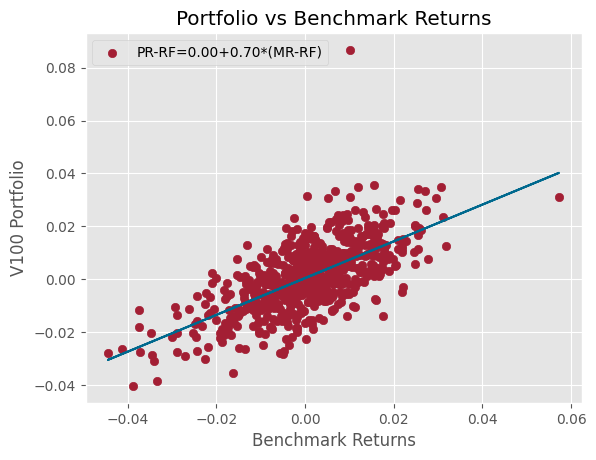

In [74]:
# plot portfolio vs benchmark returns
benchmark_returnsRF = benchmark_returns - df_rf
lm = np.polyfit(benchmark_returnsRF, portfolioReturnsRF, 1)


print(f"alpha: {252*lm[1]:.10f} \nbeta: {lm[0]:.10f}")

res = stats.linregress(benchmark_returnsRF, portfolioReturnsRF)
def tinv(p, df): return abs(t.ppf(p/2, df))


ts = tinv(0.05, len(benchmark_returnsRF)-2)
print(f"intercept (95%): {252*res.intercept:.6f}"
      f" +/- {252*ts*res.intercept_stderr:.6f}")
print(f"std error: {res.intercept_stderr}")
print(f"t-value: {res.intercept/res.intercept_stderr}")
pval = stats.t.sf(np.abs(res.intercept/res.intercept_stderr),
                  len(benchmark_returnsRF)-1) * 2  # two-sided pvalue = Prob(abs(t)>tt)
print(f'pvalue = {pval:0.10f}')


plt.style.use("ggplot")
plt.title('Portfolio vs Benchmark Returns')
plt.scatter(benchmark_returnsRF, portfolioReturnsRF, color="#A31F34")
plt.plot(benchmark_returnsRF, lm[1] + lm[0] *
         benchmark_returnsRF, color="#00698E")
plt.ylabel("V100 Portfolio")
plt.xlabel("Benchmark Returns")
plt.legend([f'PR-RF={lm[1]:.2f}+{lm[0]:.2f}*(MR-RF)'], loc="upper left")
plt.show()

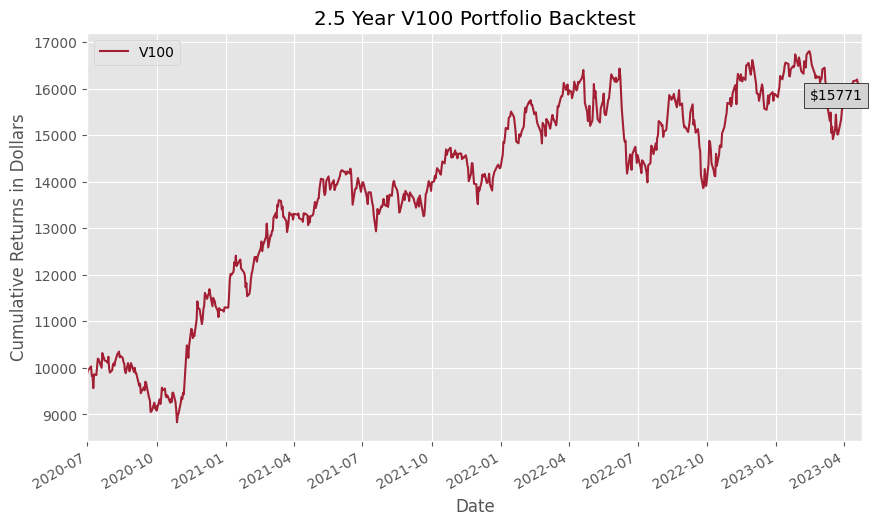

15771.344342899509
2023-04-25 00:00:00-04:00


In [75]:
# Plot solo returns
startingAmt = 10000
cumReturnsPlt = cumulative_returns * startingAmt
cumReturnsPlt.plot(figsize=(10, 6), color="#A31F34")
plt.text(cumReturnsPlt.index[-1], cumReturnsPlt.iloc[-1],
         f'${cumReturnsPlt.iloc[-1]:.0f}', ha='right', bbox=dict(facecolor='lightgrey', edgecolor='black'))
plt.title(f'2.5 Year V100 Portfolio Backtest')
plt.xlabel('Date')
plt.ylabel('Cumulative Returns in Dollars')
plt.legend(['V100', f"Benchmark ({benchmark})"])
plt.margins(x=0)
plt.show()
print(cumReturnsPlt.iloc[-1])
print(cumReturnsPlt.index[-1])


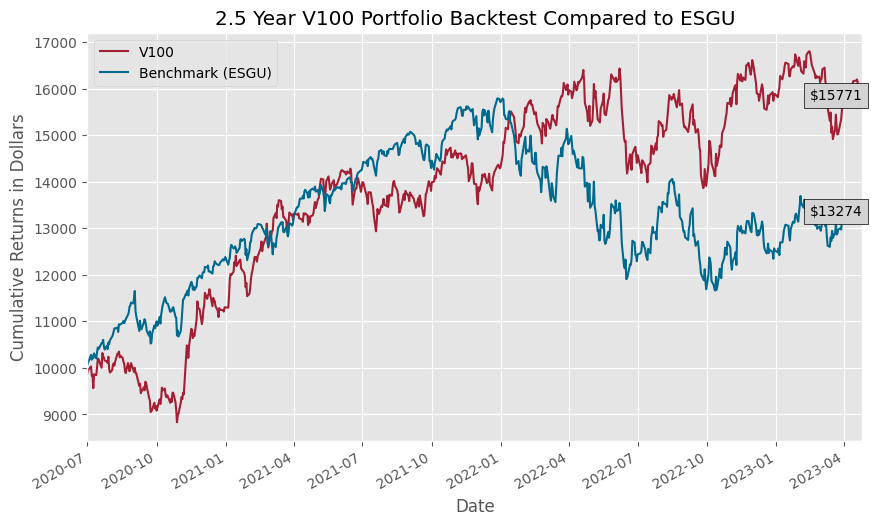

In [76]:
# Plot the cumulative returns of the portfolio
startingAmt = 10000
cumReturnsPlt = cumulative_returns * startingAmt
cumBenchReturnsPlt = cum_bench_returns * startingAmt
cumReturnsPlt.plot(figsize=(10, 6), color="#A31F34")
plt.text(cumReturnsPlt.index[-1], cumReturnsPlt.iloc[-1],
         f'${cumReturnsPlt.iloc[-1]:.0f}', ha='right', bbox=dict(facecolor='lightgrey', edgecolor='black'))
cumBenchReturnsPlt.plot(figsize=(10, 6), color="#00698E")
plt.text(cumBenchReturnsPlt.index[-1], cumBenchReturnsPlt.iloc[-1],
         f'${cumBenchReturnsPlt.iloc[-1]:.0f}', ha='right', bbox=dict(facecolor='lightgrey', edgecolor='black'))
plt.title(f'2.5 Year V100 Portfolio Backtest Compared to {benchmark}')
plt.xlabel('Date')
plt.ylabel('Cumulative Returns in Dollars')
plt.legend(['V100',f"Benchmark ({benchmark})"])
plt.margins(x=0)
plt.show()


In [77]:
# NOT USED
# Q32020 = ('2020-07-01', '2020-09-31')
# Q42020 = ('2020-10-01', '2020-12-31')
# Q12021 = ('2021-01-01', '2021-03-31')
# Q22021 = ('2021-04-01', '2021-06-31')
# Q32021 = ('2021-07-01', '2021-09-31')
# Q42021 = ('2021-10-01', '2021-12-31')
# Q12022 = ('2022-01-01', '2022-03-31')
# Q22022 = ('2022-04-01', '2022-06-31')
# Q32022 = ('2022-07-01', '2022-09-31')
# Q42022 = ('2022-10-01', '2022-12-31')
# Q12023 = ('2023-01-01', '2023-03-31')

riskfree = "^IRX"
df = yf.download(riskfree, start="2020-06-30", end="2023-03-31")
rfRate = (df[['Close']]/(252*100))

# Load historical price data using yfinance
ticker = "SPY"  # Replace with your desired stock ticker
df = yf.download(ticker, start="2020-06-30", end="2023-03-31")
# Group prices by quarter and calculate the quarterly returns
spy_returns = df[['Close']].pct_change() - rfRate
SPYQuarterReturns = df.resample('Q').last().pct_change()["Close"].dropna()*100

# Load historical price data using yfinance
ticker = "ESGU"  # Replace with your desired stock ticker
df = yf.download(ticker, start="2020-06-30", end="2023-03-31")
# Group prices by quarter and calculate the quarterly returns
esgu_returns = df[['Close']].pct_change() - rfRate
ESGUQuarterReturns = df.resample('Q').last().pct_change()["Close"].dropna()*100

portfolioPrices = (prices_df.iloc[:, 2:] * weights).sum(axis=1)
portfolioQuarterReturns = portfolioPrices.resample('Q').last().pct_change()*100

# print(SPYQuarterReturns)
# print(ESGUQuarterReturns.tolist())
# print(portfolioQuarterReturns.tolist()[:-1])

sharpe_ratioSPY = (np.mean(spy_returns)*252) / \
    (np.std(spy_returns, ddof=1) * 252**(1/2))
print(sharpe_ratioSPY)
print(np.std(spy_returns, ddof=1) * 252**(1/2))

sharpe_ratioESGU = (np.mean(esgu_returns)*252) / \
    (np.std(esgu_returns, ddof=1) * 252**(1/2))
print(sharpe_ratioESGU)
print(np.std(esgu_returns, ddof=1) * 252**(1/2))


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
Close    0.554828
dtype: float64
Close    0.187746
dtype: float64
Close    0.4932
dtype: float64
Close    0.192143
dtype: float64


/Users/nicholasliu/.virtualenvs/jupitertrading/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3430: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)


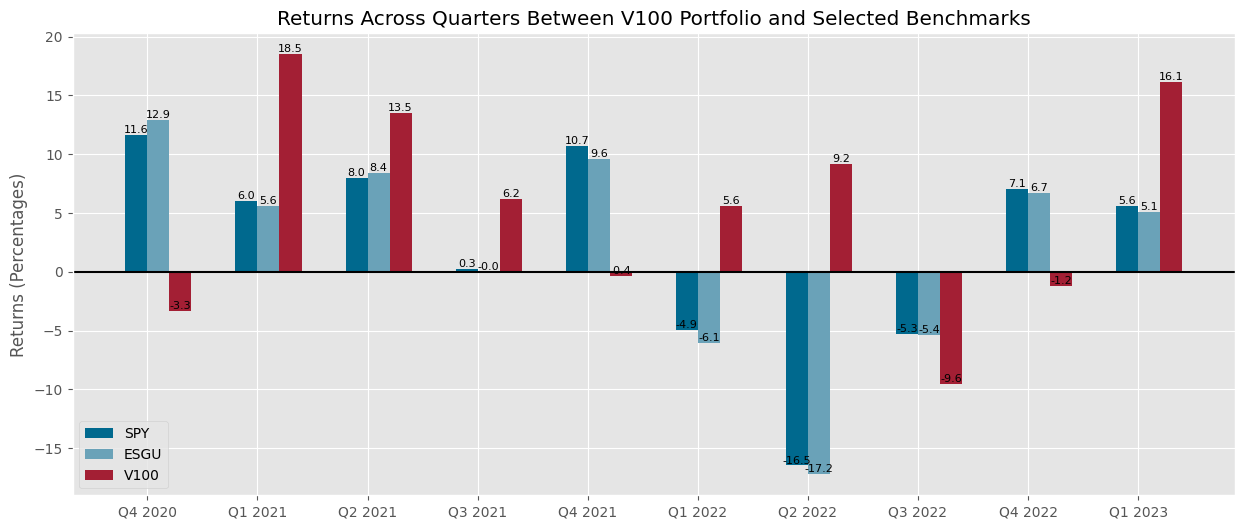

In [78]:
# quarters
time_periods = ['Q4 2020',
                'Q1 2021', 'Q2 2021', 'Q3 2021', 'Q4 2021', 
                'Q1 2022', 'Q2 2022', 'Q3 2022', 'Q4 2022',
                'Q1 2023']
spyVals = SPYQuarterReturns.tolist()[1:]
esguVals = ESGUQuarterReturns.tolist()[1:]
portVals = portfolioQuarterReturns.tolist()[1:-2]

# Set the width of each bar
bar_width = 0.2

# Create a figure and axis object
fig, ax = plt.subplots(figsize=(15, 6))

# Create bar plot for values_1
x_positions_1 = np.arange(len(time_periods))
bars1 = ax.bar(x_positions_1, spyVals, width=bar_width,
               label='SPY', color="#00698E")

for i, bar in enumerate(bars1):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width() / 2, height,
            f"{spyVals[i]:.1f}", ha='center', va='bottom', fontsize="8")

# Create bar plot for values_2
x_positions_2 = x_positions_1 + bar_width
bars2 = ax.bar(x_positions_2, esguVals, width=bar_width, label='ESGU', color="#6AA2B8")

for i, bar in enumerate(bars2):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width() / 2, height,
            f"{esguVals[i]:.1f}", ha='center', va='bottom', fontsize="8")

# Create bar plot for values_3
x_positions_3 = x_positions_2 + bar_width
bars3 = ax.bar(x_positions_3, portVals, width=bar_width, label='V100', color= "#A31F34")

for i, bar in enumerate(bars3):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width() / 2, height,
            f"{portVals[i]:.1f}", ha='center', va='bottom', fontsize="8")

# Set x-axis ticks and labels
ax.set_xticks(x_positions_1 + bar_width / 2)
ax.set_xticklabels(time_periods)
ax.axhline(y=0, color='black')

# Set y-axis label
ax.set_ylabel('Returns (Percentages)')

# Set chart title and legend
ax.set_title('Returns Across Quarters Between V100 Portfolio and Selected Benchmarks')
ax.legend(loc="lower left")

# Show the chart
plt.show()

In [79]:
# average quarterly returns
print(np.mean(spyVals))
print(np.mean(esguVals))
print(np.mean(portVals))


2.2512668823798045
1.9658409926242875
5.461897419683776


In [80]:
# portfolioMonthlyReturns = portfolioPrices.resample(
#     'M').last().pct_change().iloc[::-1]


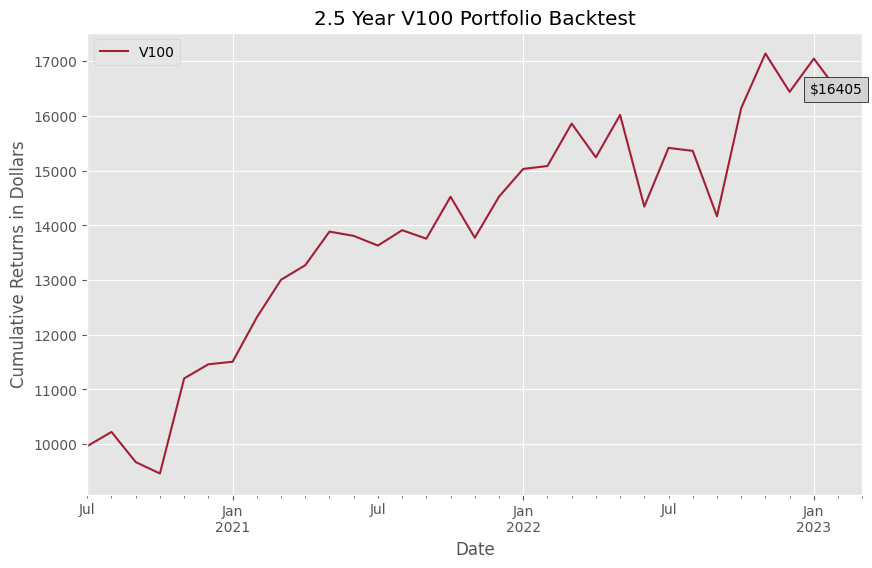

In [81]:
portfolioMonthlyReturns = portfolioPrices.resample('M').last().pct_change().tz_localize(None)[1:-1] - rfRate.resample('M').last().iloc[1:, 0]
portfolioMonthlyReturns.to_csv('portfolioMonthlyReturns.csv', index=True)
# print(portfolioMonthlyReturns)

cumulative_returns_monthly = (1 + portfolioMonthlyReturns).cumprod()

# Plot solo returns
startingAmt = 10000
cumReturnsPlt = cumulative_returns_monthly * startingAmt
cumReturnsPlt.plot(figsize=(10, 6), color="#A31F34")
plt.text(cumReturnsPlt.index[-1], cumReturnsPlt.iloc[-1],
         f'${cumReturnsPlt.iloc[-1]:.0f}', ha='right', bbox=dict(facecolor='lightgrey', edgecolor='black'))
plt.title(f'2.5 Year V100 Portfolio Backtest')
plt.xlabel('Date')
plt.ylabel('Cumulative Returns in Dollars')
plt.legend(['V100', f"Benchmark ({benchmark})"])
plt.show()
# print(cumReturnsPlt.iloc[-1])
# print(cumReturnsPlt.index[-1])
